In [1]:
%matplotlib inline 
import pandas
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cmx
import matplotlib.colors

In [2]:
from analysis import prepare_df, compare_job_traces, job_view_stats, gantt_plot
from analysis import colors_for_values, running_concurrently, waiting_over_time

# Single simulation analysis

In [8]:
df = prepare_df("experiments/bin-packing/control-out-trace.csv")
df.head()

,job_id,instance_id,submit_time_ms,mesos_start_time_ms,start_time_ms,end_time_ms,hostname,slave_id,status,reason,user,mem,cpus,job_name,requested_run_time,requested_status,run_time_ms
0,591309ac-acf8-4c81-a210-601ca6904d2f,99290a57-480a-419a-9891-41cf1d8eba72,90200,2520003,2520003,3630001,16,2ed1dc7c-2fce-4e77-bad1-fa08a4370299,:instance.status/success,NaN,b,28561.0,2.0,dummy_job,1089021,finished,1109998
1,591309ac-77a5-4d9e-99aa-bff694b6ee7a,a59b2006-65f8-40c7-bc20-5b6157501dc5,90206,2520003,2520003,3780001,7,b2aabbfa-8d85-492c-89c8-1e9c1869d1eb,:instance.status/success,NaN,b,27819.0,3.0,dummy_job,1238624,finished,1259998
2,591309ac-6221-4c1e-a5a8-93e1f4e40e66,98500055-3a70-4625-906a-b3a0f014d4dc,90169,2520003,2520003,3510001,8,22950241-c1fb-406c-8501-0c8d538d1854,:instance.status/success,NaN,c,29660.0,3.0,dummy_job,962966,finished,989998
3,591309ac-d893-40d5-9d0b-3bb5313686dc,9e115421-493c-4d3f-82d7-cd9d65bf8c90,90082,2520003,2520003,3870001,9,758ae34a-a321-4363-bbd2-11e499123eeb,:instance.status/success,NaN,d,27516.0,3.0,dummy_job,1335637,finished,1349998
4,591309ac-a2e0-44f1-a777-7034adfbef7b,af6f9b41-8716-48f0-b2ec-3f0a16b92ba5,90095,2550003,2550003,4110001,14,8e0754cc-8f4b-40f7-9dc6-982359d227fc,:instance.status/success,NaN,d,32210.0,1.0,dummy_job,1559090,finished,1559998


In [7]:
%ls

analysis.ipynb      example-hosts.json      example-trace.json  wil-notes/
analysis.py         example-out-trace2.csv  experiments/
example-config.edn  example-out-trace.csv   __pycache__/


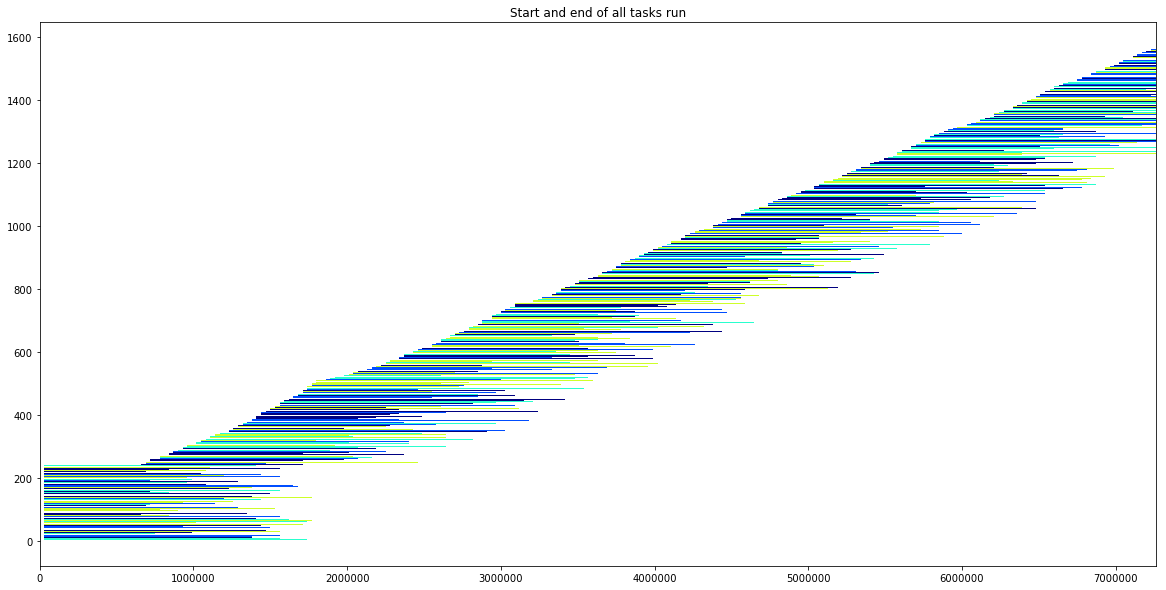

In [9]:
df = df.sort_values("start_time_ms", ascending=True).reset_index(drop=True)
plt.figure(figsize=(20,10))
gantt_plot(df.job_id, df.start_time_ms, df.end_time_ms, colors_for_values(df.user), texts = ["X" if status == ":instance.status/failed" else "" for status in df.status])
plt.title("Start and end of all tasks run")

In [10]:
utilization_ts = running_concurrently(df)
utilization_ts["cycle"] = np.floor(utilization_ts.time_ms/1000) # This assumes cycle is > 1000ms
utilization_ts = utilization_ts.groupby("cycle").last().reset_index(drop=True)

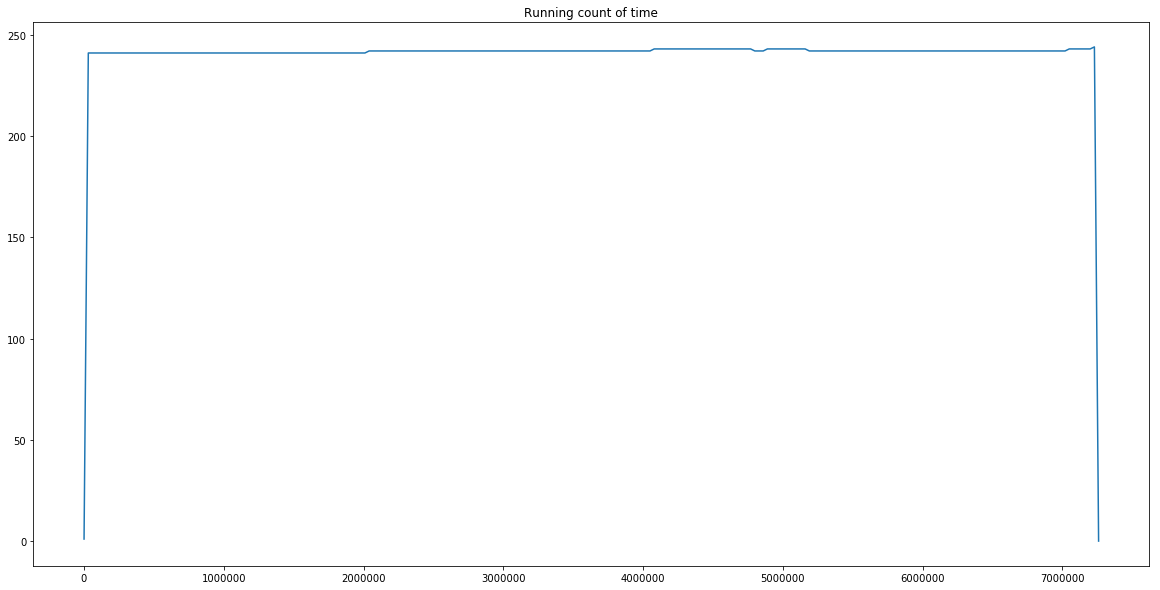

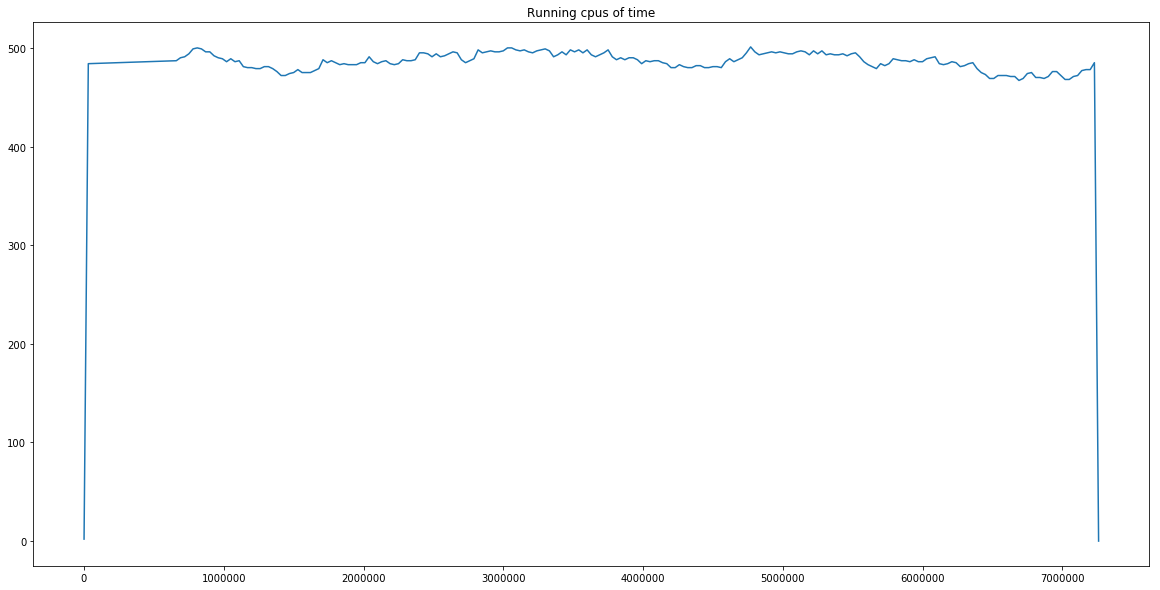

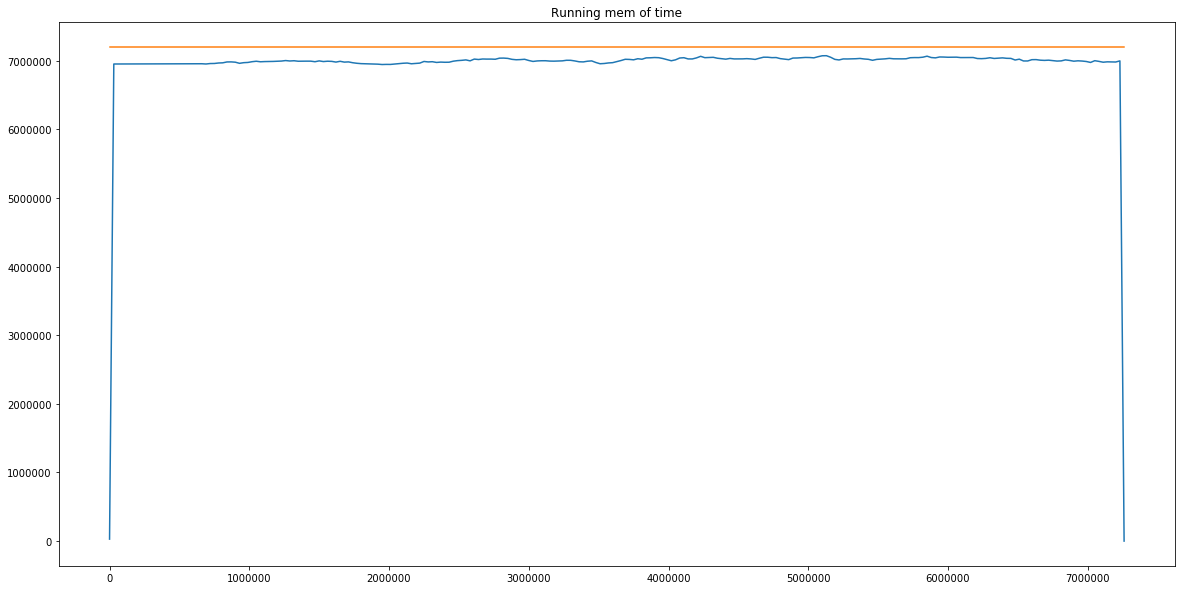

In [12]:
plt.figure(figsize=(20,10))
plt.plot(utilization_ts["time_ms"], utilization_ts["count"])
plt.title("Running count of time")
plt.figure(figsize=(20,10))
plt.plot(utilization_ts["time_ms"], utilization_ts["cpus"])
plt.title("Running cpus of time")
plt.figure(figsize=(20,10))
plt.plot(utilization_ts["time_ms"], utilization_ts["mem"])
plt.plot(utilization_ts["time_ms"], [240000*30]*len(utilization_ts))
plt.title("Running mem of time")

## Point in time analysis

In [317]:
[per_host, per_user, waiting, running_at, df] = analyze_state(df, df.start_time_ms.median())

In [318]:
per_host

,mem,cpus,count
hostname,,,
0,19073.0,20.0,9
1,11753.0,20.0,6
2,13499.0,20.0,7
3,16753.0,20.0,9
4,19425.0,16.0,10


In [319]:
per_user

,mem,cpus,count
user,,,
a,26277.0,38.0,14
b,15935.0,19.0,8
c,14058.0,11.0,7
d,24233.0,28.0,12


In [320]:
waiting

,job_id,instance_id,submit_time_ms,mesos_start_time_ms,start_time_ms,end_time_ms,hostname,slave_id,status,reason,user,mem,cpus,job_name,requested_run_time,requested_status,run_time_ms
1070,58f8f051-330f-4166-8c0a-bb09e933bf23,b1559aca-2b9b-4b1d-acb9-07eb91b17259,975017,1000003,1000003,1025092,0,bb57002a-75d4-4feb-8695-95e04a1b9c4f,:instance.status/success,NaN,d,2668.0,2.0,dummy_job,51022/5,finished,25089
1072,58f8f051-a3ab-421a-b529-b4e96fd0cbbc,f6d216f0-6162-4190-8f17-5bae22bb6d05,975019,1000003,1000003,1050001,0,bb57002a-75d4-4feb-8695-95e04a1b9c4f,:instance.status/success,NaN,d,1101.0,3.0,dummy_job,52119/2,finished,49998
1074,58f8f051-d333-4dff-8ed7-82c1ca4d79cb,360ffb00-eac8-4750-88ac-c9d8080a07cd,975018,1000003,1000003,1050001,0,bb57002a-75d4-4feb-8695-95e04a1b9c4f,:instance.status/success,NaN,d,1684.0,2.0,dummy_job,199951/5,finished,49998
1076,58f8f051-057f-4166-a7d0-9e80b139e90f,3ecbaddd-f67a-42ec-ab3a-30f604f2f29a,975030,1000003,1000003,1025092,1,c0360184-c619-48c5-9fee-048e7d5634c8,:instance.status/success,NaN,a,2009.0,1.0,dummy_job,159881/10,finished,25089
1079,58f8f051-ffc9-4cf5-929c-98c58da18603,00045956-684f-4764-9687-a7514e45d765,975025,1000003,1000003,1075001,1,c0360184-c619-48c5-9fee-048e7d5634c8,:instance.status/success,NaN,a,1429.0,1.0,dummy_job,63415,finished,74998
1080,58f8f051-2090-4e14-af98-6f3faeb563e5,b71f2aee-9c56-46a0-b775-2f46f18d6df2,975023,1000003,1000003,1050001,1,c0360184-c619-48c5-9fee-048e7d5634c8,:instance.status/success,NaN,a,1679.0,2.0,dummy_job,159848/5,finished,49998
1078,58f8f051-df85-4829-96e8-621f1294c19a,dfefbda2-9dac-47ea-9075-abdf065f8569,975027,1000003,1000003,1050001,1,c0360184-c619-48c5-9fee-048e7d5634c8,:instance.status/success,NaN,d,1830.0,1.0,dummy_job,256277/10,finished,49998


In [321]:
running_at

,job_id,instance_id,submit_time_ms,mesos_start_time_ms,start_time_ms,end_time_ms,hostname,slave_id,status,reason,user,mem,cpus,job_name,requested_run_time,requested_status,run_time_ms,count
819,58f8f051-b5fb-4704-8c1a-990fe1188f0a,9c0ca29d-5a17-4fb7-8c70-1a4ff672d6eb,925005,925023,925023,1000001,0,bb57002a-75d4-4feb-8695-95e04a1b9c4f,:instance.status/success,NaN,b,1672.0,4.0,dummy_job,282314/5,finished,74978,1
831,58f8f051-3bbe-44e1-a1cd-ee36b71f69aa,622d832a-1b30-4eb7-aaa7-585e23c472e2,850064,925023,925023,1000001,4,74f679b7-2192-45da-80a0-2a0b5c9ed6a5,:instance.status/success,NaN,d,2462.0,1.0,dummy_job,100999/2,finished,74978,1
832,58f8f051-09d1-48c5-a985-5b9edec8a8c5,fa74634d-28fe-4241-93ab-a4e0d64ad173,925003,925023,925023,1000001,4,74f679b7-2192-45da-80a0-2a0b5c9ed6a5,:instance.status/success,NaN,b,2748.0,1.0,dummy_job,279562/5,finished,74978,1
820,58f8f051-f996-406e-b391-42903242e6e5,928191f4-c041-4e50-9c32-9ce5c0336d67,925000,925023,925023,1000001,0,bb57002a-75d4-4feb-8695-95e04a1b9c4f,:instance.status/success,NaN,d,2545.0,1.0,dummy_job,280574/5,finished,74978,1
823,58f8f051-7a14-4c0f-9784-12d7338fb18d,e9c7190a-b82d-4f5a-93a6-b06d2bec9d1b,850077,925023,925023,1000001,1,c0360184-c619-48c5-9fee-048e7d5634c8,:instance.status/success,NaN,d,1709.0,2.0,dummy_job,530181/10,finished,74978,1
829,58f8f051-c74d-40e0-a822-153c2f72ae15,43fe79d7-ec7a-4e18-bb3c-1d74f2fa2a3b,850061,925023,925023,1000001,3,5f839e29-6e2c-4068-af1a-b51564290f02,:instance.status/success,NaN,a,1358.0,4.0,dummy_job,326821/5,finished,74978,1
848,58f8f051-20ad-411f-8d7a-3915900ee65d,7421f65e-20f1-41ef-a7d2-a82af48cf57a,850067,950003,950003,1025092,4,74f679b7-2192-45da-80a0-2a0b5c9ed6a5,:instance.status/success,NaN,a,1603.0,4.0,dummy_job,55059,finished,75089,1
847,58f8f051-243a-4428-be1c-bc48ec11f937,68ffece0-2d07-45a0-ae54-93ff10afae0f,925009,950003,950003,1025092,4,74f679b7-2192-45da-80a0-2a0b5c9ed6a5,:instance.status/success,NaN,b,1586.0,1.0,dummy_job,307906/5,finished,75089,1
846,58f8f051-df1a-4f9f-8c3d-f4af3d0fe003,c0472d66-8b2f-470c-b2c9-87b00654b629,850066,950003,950003,1000001,4,74f679b7-2192-45da-80a0-2a0b5c9ed6a5,:instance.status/success,NaN,a,2888.0,2.0,dummy_job,134269/5,finished,49998,1
834,58f8f051-6eff-4f2d-91cd-542d98571196,316c1e76-7768-4b38-8f86-6ced598fd846,925018,950003,950003,1025092,0,bb57002a-75d4-4feb-8695-95e04a1b9c4f,:instance.status/success,NaN,d,1086.0,1.0,dummy_job,574063/10,finished,75089,1


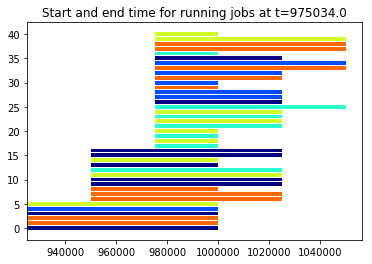

In [322]:
gantt_plot(running_at.job_id, 
           running_at.start_time_ms, 
           running_at.end_time_ms, 
           colors_for_values(running_at.hostname))
plt.title("Start and end time for running jobs at t={}".format(df.start_time_ms.median()))

# Comparing simulation runs

In [351]:
compare_df = compare("simulator_files/experiments/big/out-trace.csv", 
                     "simulator_files/experiments/big/out-trace2.csv")

In [352]:
compare_df[abs(compare_df.ratio-1) > 0.001][["end_time_ms_x", "end_time_ms_y"]]

,end_time_ms_x,end_time_ms_y


In [342]:
compare_df[compare_df.start_time_ms_x != compare_df.start_time_ms_y][["submit_time_ms_x", "start_time_ms_x","submit_time_ms_y", "start_time_ms_y"]].sort_values("start_time_ms_x")

,submit_time_ms_x,start_time_ms_x,submit_time_ms_y,start_time_ms_y
